---
# Notebook para selecionar variáveis que vão entrar no modelo

Vou testar 3 abordagens de seleção de variáveis:

- __Boruta__:
O Boruta é um método de seleção de variáveis que utiliza algoritmos de aprendizado, geralmente Random Forest, para identificar quais features possuem relevância estatística para o modelo. Ele cria "shadow features" (cópias embaralhadas das variáveis originais) e compara a importância das features reais com essas cópias, eliminando aquelas que não se destacam, de forma a manter apenas as variáveis que contribuem significativamente.

- __Boruta + RFECV__:
Nesta abordagem combinada, o Boruta é utilizado inicialmente para reduzir o conjunto de variáveis, identificando aquelas com relevância estatística. Em seguida, o RFECV refina ainda mais esse subconjunto, eliminando possíveis redundâncias e otimizando o conjunto final de features para melhorar a performance do modelo.

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
from matplotlib import pyplot as plt
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

from src.utils.features_manager import get_features_by_property
from src.utils.transformers import OptBinningEncoder, NumericMissing

# Configs Pandas
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

warnings.filterwarnings("ignore")

In [2]:
project_root = Path().resolve().parents[0]

In [3]:
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "train.parquet"))

In [4]:
df.shape

(114506, 39)

# Configs

## Variáveis que passarão pelo processo de seleção 

In [5]:
features_config_path = os.path.join(project_root, "src", "data", "config", "features.yaml")
features_to_select = get_features_by_property(yaml_path=features_config_path, property_name="role", property_value="descriptive")

In [6]:
X = df[features_to_select]
y = df["fraude"]

In [7]:
print("Features to select: ", features_to_select)

Features to select:  ['monto', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'hour', 'weekday', 'dawn_operation', 'monto_div_a', 'monto_div_b', 'monto_div_c', 'monto_div_d', 'monto_div_e', 'monto_div_f', 'monto_div_h', 'monto_div_k', 'monto_div_l', 'monto_div_m', 'monto_div_hour', 'monto_div_weekday', 'N_op', 'f_lower', 'l_lower', 'm_lower', 'n_lower']


# Optbinning Encoder

Vamos realizar o encoding de variáveis categóricas com o Optbinning, criando um sklearn encoder.

Este método funciona avaliando de forma otimizada os pontos de corte (bins) para cada variável, buscando maximizar a separação entre as classes de um problema binário. Ele utiliza algoritmos de otimização que consideram critérios de performance e estabilidade para definir as partições mais relevantes dos dados. Essa abordagem é vantajosa como encoder, pois automatiza o processo de discretização, preserva a informação discriminante e aumenta a interpretabilidade do modelo, além de potencialmente melhorar a performance na classificação.

In [8]:
features_to_encode = get_features_by_property(yaml_path=features_config_path, property_name="encode", property_value=True)
features_to_encode

['g']

In [9]:
encoder = OptBinningEncoder(features=features_to_encode)
encoder.fit(X, y)
X = encoder.transform(X)

In [10]:
X[features_to_encode]

,g
0,-0.093884
1,0.361803
2,-0.093884
3,-0.093884
4,-0.093884
...,...
114501,-0.093884
114502,0.361803
114503,-0.093884
114504,-0.093884


# Fill Numeric Missing

In [ ]:
features_to_fill_missing = get_features_by_property(yaml_path=features_config_path, property_name="fill_numeric_missing", property_value=True)
numeric_missing_encoder = NumericMissing(features_to_fill_missing)
X = numeric_missing_encoder.fit_transform(X)

# Boruta

Parâmetros selecionados:
- `estimator=RandomForestClassifier(class_weight="balanced", max_depth=3)`: Modelo rápido de ser treinado, permitindo paralelização e estimação de _feature importance_
- `n_estimators=100`: Boa quantidade de árvores
- `alpha=0.01`: Críterio dos p-valores das variáveis que serão rejeitados
- `max_iter=100`: Iterações suficientes para boa convergência da solução

In [12]:
random_forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=3, random_state=911)

boruta_selector = BorutaPy(
    estimator=random_forest,
    n_estimators=100,
    alpha=0.01,
    max_iter=100,
    random_state=911,
    verbose=2
).fit(X.values, y.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	31
Tentative: 	4
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	31
Tentative: 	2
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	31
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	31
Tentative: 	2
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	31
Tentative: 	2
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	32
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	32
Tentative: 	1
Rejected: 	2
I

In [13]:
boruta_selection = X.columns[boruta_selector.support_].tolist()
boruta_selection


['monto',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'l',
 'm',
 'n',
 'o',
 'p',
 'hour',
 'dawn_operation',
 'monto_div_a',
 'monto_div_b',
 'monto_div_c',
 'monto_div_d',
 'monto_div_e',
 'monto_div_f',
 'monto_div_h',
 'monto_div_k',
 'monto_div_l',
 'monto_div_m',
 'monto_div_hour',
 'monto_div_weekday',
 'N_op',
 'f_lower',
 'l_lower',
 'm_lower',
 'n_lower']

# Boruta + RFECV

In [ ]:
X = X[boruta_selection]

rfecv_selector = RFECV(
    estimator=random_forest, 
    step=1, 
    cv=3, 
    scoring="roc_auc", 
    n_jobs=1,
    verbose=2
)

rfecv_selector.fit(X.values, y.values)

print(f"Optimal number of features: {rfecv_selector.n_features_}")

rfe_selection = X.columns[rfecv_selector.support_].tolist()
rfe_selection

Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 featur

['monto',
 'a',
 'b',
 'f',
 'g',
 'h',
 'l',
 'm',
 'n',
 'o',
 'p',
 'monto_div_a',
 'monto_div_c',
 'monto_div_d',
 'monto_div_f',
 'monto_div_h',
 'monto_div_l',
 'monto_div_m',
 'monto_div_hour',
 'N_op',
 'f_lower',
 'l_lower',
 'm_lower',
 'n_lower']

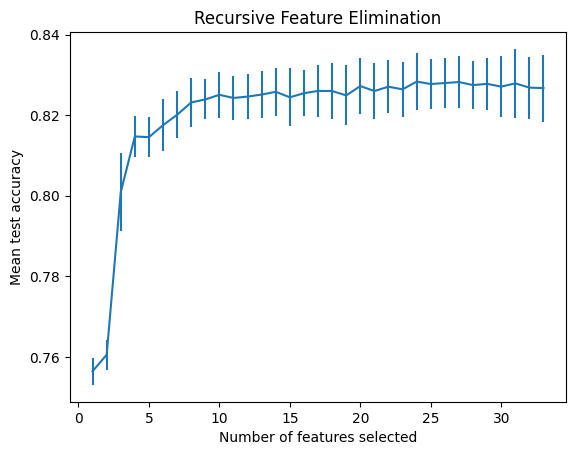

In [16]:
cv_results = pd.DataFrame(rfecv_selector.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [27]:
rfecv_selector.estimator_.fit(X[boruta_selection], y)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x204B6CC6F40)

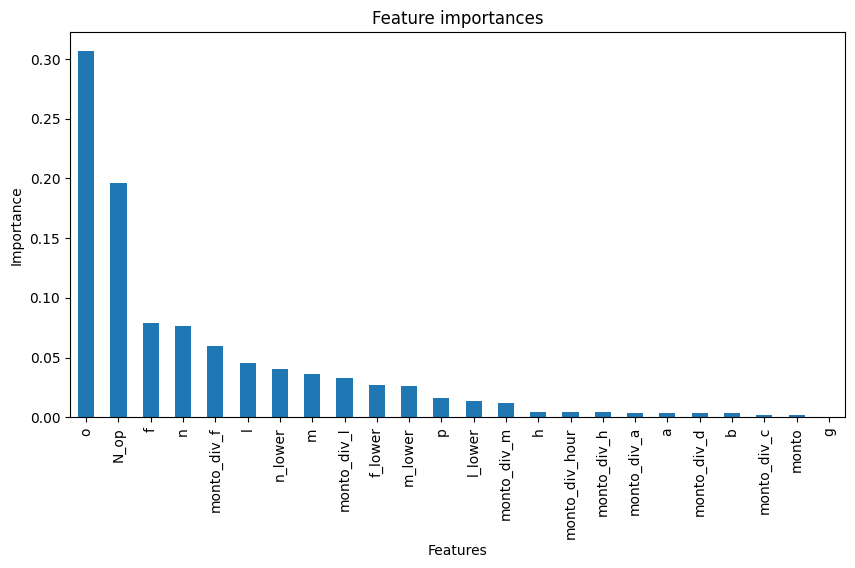

In [18]:
importances = pd.Series(random_forest.feature_importances_, index=random_forest.feature_names_in_).sort_values(ascending=False)
importances.plot(kind="bar", figsize=(10, 5))
plt.title("Feature importances")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()